# Assignment 1

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [4]:
import pandas as pd
import numpy as np
import re
import os
import requests
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [5]:
# Download necessary resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Load dataset
df = pd.read_csv(r"C:\Users\matth\Desktop\MSBA\BSAN 6200\Reviews.csv")

print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [7]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [8]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817               

In [9]:
# Display the entire review text 
pd.set_option('display.max_colwidth', None)

In [10]:
# Add a new column for text length
df["Text_Length"] = df["Text"].astype(str).apply(len)

# Display descriptive statistics for text length
print(df["Text_Length"].describe())

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: Text_Length, dtype: float64


In [11]:
# Read a few random review samples
print(df["Text"].sample(10, random_state=45))

300665                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I have used this product before and found it to be the best product for jerk chicken. I could not find this product anywhere until my sister suggested I look on Amazon. There is nothing like it. It has a very unique taste.  I have tried other products out there and nothing compares to Busha Brownes Authentic Jerk Seasoning. I find myself wanting to go to jamaica and drink some rum and have jerk chicken.
167

In [12]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [13]:
# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Handle missing values
    
    # 1. Remove HTML tags using a regex pattern
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags

    # 2. Replace URLs with a placeholder "URL"
    text = re.sub(r'http[s]?://\S+', 'URL', text)

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Normalize whitespace (remove any leftover <br /> or extra spaces)
    text = re.sub(r"\s+", " ", text).strip()

    # 5. Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-z\s]", "", text)

    # 6. Tokenize the text into words
    words = word_tokenize(text)

    # 7. Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # 8. Lemmatize the tokens
    cleaned_text = [lemmatizer.lemmatize(word) for word in words]

    # 9. Replace multiple spaces with a single space
    cleaned_text = " ".join(cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [14]:
# Select 100 random rows
random_sample = df.sample(100)

In [15]:
# Apply the updated cleaning function to the Text column
random_sample["Cleaned_Text"] = random_sample["Text"].apply(clean_text)

In [16]:
# Spot-checking
spotcheck_sample = random_sample[["Text", "Cleaned_Text"]].sample(5, random_state=45)
print(spotcheck_sample)

## VADER

In [18]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

In [19]:
# Add negative words or phrases
custom_lexicon = {
    "meh": -0.5,
    "could be better": -0.3,
    "not great": -0.6,
    "disappointed": -0.8,
    "not happy": -0.7,
    "good product": 0.6,
    "love it": 0.8,
    "great taste": 0.7,
    "highly recommend": 0.9,
    "would buy again": 0.7,
    "favorite": 0.8,
    "best product": 0.9,
    "delicious": 0.8,
    "wonderful": 0.75,
    "impressed": 0.7,
    "good quality": 0.7,
    "pleasantly surprised": 0.6,
    "better than expected": 0.7,
    "amazing": 0.9,
    "perfect": 1.0,
    "satisfied": 0.6,
    "tasty": 0.7,
    "excited to try": 0.7,
    "nice texture": 0.6,
    "will buy again": 0.7
}

# Extend the lexicon
analyzer.lexicon.update(custom_lexicon)

In [20]:
# Tokenize the Cleaned_Text once and store it in a new column 'Tokens'
random_sample['Tokens'] = random_sample['Cleaned_Text'].apply(word_tokenize)

In [21]:
# Apply Feature Engineering on the pre-tokenized text
def extract_features_from_tokens(tokens):
    word_count = len(tokens)
    unique_word_count = len(set(tokens))
    avg_word_length = sum(len(word) for word in tokens) / word_count if word_count else 0

    # Sentiment analysis with VADER
    sentiment = analyzer.polarity_scores(" ".join(tokens))  # VADER expects a string, not tokens

    return [word_count, unique_word_count, avg_word_length, sentiment['compound']]

# Now apply the feature extraction on the 'Tokens' column (pre-tokenized)
random_sample[['Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']] = random_sample['Tokens'].apply(
    lambda x: pd.Series(extract_features_from_tokens(x)))

# Spot-check the results
print(random_sample[['Text', 'Cleaned_Text', 'Tokens', 'Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']].head())


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Text  \
432887                                                                                                                                                           

In [22]:
def classify_sentiment(sentiment_score):
    if sentiment_score > 0.1:
        return "Positive"
    elif sentiment_score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment classification based on VADER sentiment score
random_sample['Sentiment_Label'] = random_sample['Sentiment_Score'].apply(classify_sentiment)

# Show some of the classified sentiments
print(random_sample[['Cleaned_Text', 'Sentiment_Score', 'Sentiment_Label']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                      Cleaned_Text  \
432887                                                                                                                                                                                                                                                                                                                    smartbones dental dog chew perfect treat two pomeranian one pembroke corgi rawhide nothing upset sensitive stomach dance give daily chew   
285823                                                                                      

In [23]:
# Extract sentiment predictions from VADER
random_sample['VADER_Sentiment'] = random_sample['Sentiment_Score'].apply(
    lambda score: 'Positive' if score > 0.05 else 'Negative' if score < -0.05 else 'Neutral'
)

In [24]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text', 'VADER_Sentiment']].sample(5, random_state=45)

print(spotcheck_sample)

In [25]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print("-" * 50)

Review Text: SmartBones Dental Dog Chews are the perfect treat for my two pomeranians and one Pembroke Corgi. No rawhide, nothing to upset their sensitive stomachs. They "dance" when I give them their daily chew.
VADER Sentiment: Positive
--------------------------------------------------
Review Text: Chamomile is one of those herbs that are ancestors thought that they couldn't live without. It settles the digestive track, aids sleep, and is a mild anti-inflammatory. This is a very good chamomile tea - gentle and yet tasty. Want a good night's sleep? End your evening with a cup of Bigelow Cozy Chamomile Herbal Tea.<br /><br />(Review of Bigelow Cozy Chamomile Herbal Tea Keurig K-Cups)
VADER Sentiment: Positive
--------------------------------------------------
Review Text: I wish I would have heeded another reviewer's comments about this product not tasting good. She was right. Sometimes the majority is wrong! These are not like Honey Grahams, and in fact, they have very little "graham

## TextBlob

In [27]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity, 'Positive' if blob.sentiment.polarity > 0.05 else ('Negative' if blob.sentiment.polarity < -0.05 else 'Neutral')

# Apply the function and append new columns
random_sample[['TextBlob_Polarity', 'TextBlob_Subjectivity', 'TextBlob_Sentiment']] = random_sample['Cleaned_Text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Display the updated DataFrame
random_sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,Tokens,Word_Count,Unique_Word_Count,Avg_Word_Length,Sentiment_Score,Sentiment_Label,VADER_Sentiment,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Sentiment
432887,432888,B003ZNZ590,A1XAUYDVTHNTG4,Kathy Cheyne,0,0,5,1347235200,safe treat for poms,"SmartBones Dental Dog Chews are the perfect treat for my two pomeranians and one Pembroke Corgi. No rawhide, nothing to upset their sensitive stomachs. They ""dance"" when I give them their daily chew.",...,"[smartbones, dental, dog, chew, perfect, treat, two, pomeranian, one, pembroke, corgi, rawhide, nothing, upset, sensitive, stomach, dance, give, daily, chew]",20.0,19.0,5.850000,0.7081,Positive,Positive,0.366667,0.633333,Positive
285823,285824,B004IMIN82,A1P27BGF8NAI29,Alice in Wonderland,0,0,5,1336003200,A very good chamomile tea,"Chamomile is one of those herbs that are ancestors thought that they couldn't live without. It settles the digestive track, aids sleep, and is a mild anti-inflammatory. This is a very good chamomile tea - gentle and yet tasty. Want a good night's sleep? End your evening with a cup of Bigelow Cozy Chamomile Herbal Tea.<br /><br />(Review of Bigelow Cozy Chamomile Herbal Tea Keurig K-Cups)",...,"[chamomile, one, herb, ancestor, thought, couldnt, live, without, settle, digestive, track, aid, sleep, mild, antiinflammatory, good, chamomile, tea, gentle, yet, tasty, want, good, night, sleep, end, evening, cup, bigelow, cozy, chamomile, herbal, teareview, bigelow, cozy, chamomile, herbal, tea, keurig, kcups]",40.0,31.0,5.825000,0.8658,Positive,Positive,0.238528,0.642857,Positive
295991,295992,B001E0VNAQ,A1APD6UJH9SUIT,T. Baldwin,2,2,3,1320624000,Is what it is.. I've moved on to things with more dramatic effects,"The great news is I haven't gotten sick!<br /><br />Unfortunately after a couple months of drinking this product daily I've not felt a huge change either... I've moved on to trying Amazing Grass which has been supplementing my daily vegi intake that I wasn't getting and has had more dramatic effects on my health. I've switched from this product to taking two tablets of Lifesheild mushroom blend at night. Overall I've seemed to have missed my yearly 3 day (or so) crippling sickness<br /><br />Good will hunting,<br />Tom",...,"[great, news, havent, gotten, sickunfortunately, couple, month, drinking, product, daily, ive, felt, huge, change, either, ive, moved, trying, amazing, grass, supplementing, daily, vegi, intake, wasnt, getting, dramatic, effect, health, ive, switched, product, taking, two, tablet, lifesheild, mushroom, blend, night, overall, ive, seemed, missed, yearly, day, crippling, sicknessgood, huntingtom]",48.0,43.0,6.270833,0.7269,Positive,Positive,0.195238,0.450000,Positive
505834,505835,B003P9XGHW,A17ATYEFUBPAL7,"Nichole Green ""Nikki Green""",2,2,5,1314489600,My Babies Love this food!,"I own 4 very finicky cats, 2 of which are 1/2 Bengals and 1/2 Himalayan's, when I first introduced this to them they devoured it. It is very high quality recognizable food, you can see and smell it's tuna, and it's flaked which they love! Amazon offers it at a great price, I will continue to give them the very best and this is it. I Highly recommend Blue buffalo to any of your pets,",...,"[finicky, cat, bengal, himalayans, first, introduced, devoured, high, quality, recognizable, food, see, smell, tuna, flaked, love, amazon, offer, great, price, continue, give, best, highly, recommend, blue, buffalo, pet]",28.0,28.0,5.857143,0.9516,Positive,Positive,0.390000,0.426667,Positive
113103,113104,B0044MTGHI,A1404FCUQLKMWH,pribaby,13,13,5,1322006400,Tastes great,"I purchased this to use on my hair and it has done wonders for my hair. I purchased other brands after I purchased this brand and by far it's the best. I also eat a teaspoon of this everyday and it taste so yummy. If you are looking for coconut oil that tastes great and works wonders for your hair al

In [28]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text','VADER_Sentiment', 'TextBlob_Sentiment']].sample(5)
print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Text  \
346400                                                                                                                                                                                                                                                                                                         

In [29]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Review Text: Great products....have been happy with all of them......Namaste Foods, Gluten Free Spice Cake Mix, 26-Ounce Bags (Pack of 6)....I would recommend to every one!~
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: I own 4 very finicky cats, 2 of which are 1/2 Bengals and 1/2 Himalayan's, when I first introduced this to them they devoured it. It is very high quality recognizable food, you can see and smell it's tuna, and it's flaked which they love! Amazon offers it at a great price, I will continue to give them the very best and this is it. I Highly recommend Blue buffalo to any of your pets,
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: I eat these with crackers (unsalted tops), and crushed red pepper, or Texas Pete hot sauce.  These are a good switch out with other Compleats.  Of course, I do spice them up, but my taste is that these 

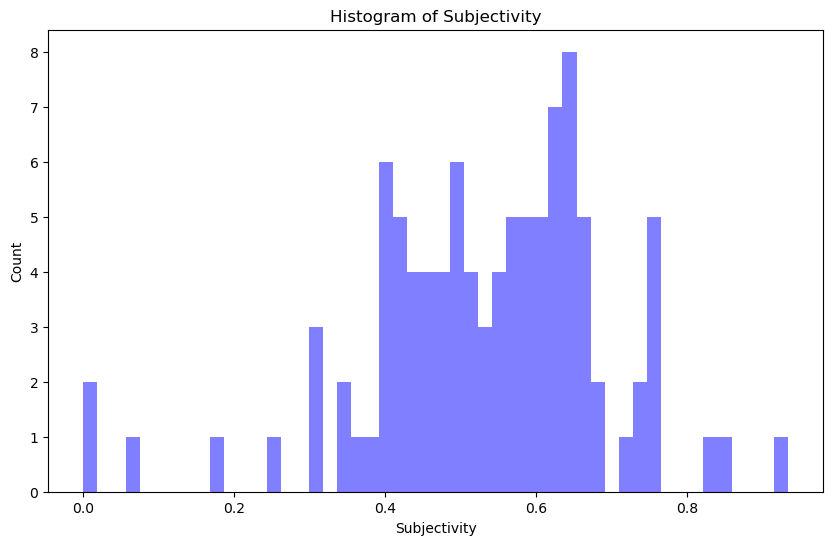

In [30]:
#Draw a histogram that shows the distribution of subjectivity: Count vs. subjectivity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Subjectivity')
plt.show()

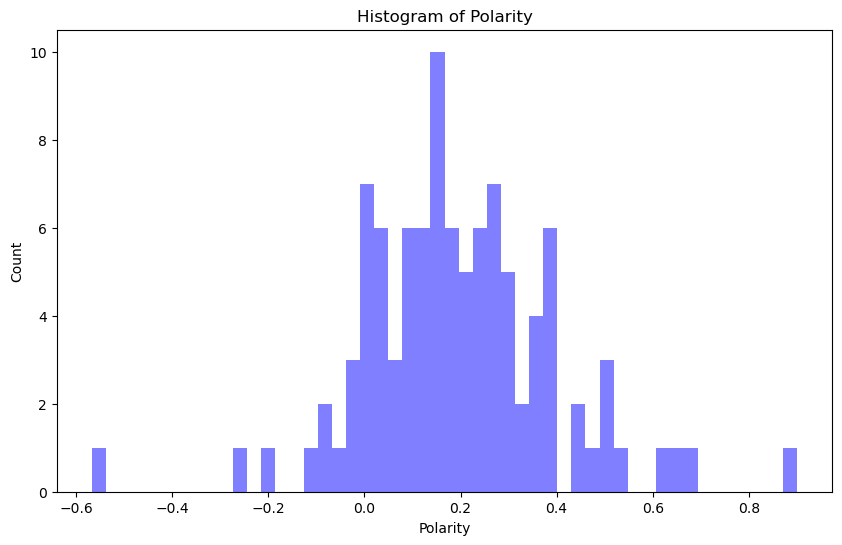

In [31]:
#Draw a histogram that shows the distribution of polarity: Count vs. polarity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()

## Analyze and Review

In [33]:
analyzer = SentimentIntensityAnalyzer()
# Initialize VADER sentiment analyzer

In [34]:
for idx, row in random_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Review Text: SmartBones Dental Dog Chews are the perfect treat for my two pomeranians and one Pembroke Corgi. No rawhide, nothing to upset their sensitive stomachs. They "dance" when I give them their daily chew.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: Chamomile is one of those herbs that are ancestors thought that they couldn't live without. It settles the digestive track, aids sleep, and is a mild anti-inflammatory. This is a very good chamomile tea - gentle and yet tasty. Want a good night's sleep? End your evening with a cup of Bigelow Cozy Chamomile Herbal Tea.<br /><br />(Review of Bigelow Cozy Chamomile Herbal Tea Keurig K-Cups)
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: The great news is I haven't gotten sick!<br /><br />Unfortunately after a couple months of drinking this product daily I've not felt a huge change either... I

In [35]:
# Find cases where models disagree
disagreed_df = random_sample[random_sample["VADER_Sentiment"] != random_sample["TextBlob_Sentiment"]]
print("\n Examples where models disagree (need manual review):")
print("-" * 50)
for idx, row in disagreed_df.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)


 Examples where models disagree (need manual review):
--------------------------------------------------
Review Text: I didn't have such luck with this product as the other reviewers--unfortunately I got SEVERE abdominal cramps the few times I tried it. Still, it's worth a try because it works for many people. Just bear in mind that if you get some bad cramping, you are probably sensitive to SENNA, the active ingredient in the tea. So stay away from other SENNA products, too. (usually labeled "Stimulant Laxative.")<br /><br />So what works for me?  Lots of the high-fiber foods every day.  Plenty of raw fruits (except banana) and vegetables (two raw carrots a day works wonders!)  Whole grains every day makes a big difference--I especially like brown rice and oatmeal. Apples are yummy: I eat one every day.  Eating beans and legumes is also very helpful.  Buy some dried lentils--they cook the fastest--and google some soup recipes. And keep products made with white flour to a minimum.<br 

In [36]:
# Find cases where models agree
agreed_df = random_sample[random_sample["VADER_Sentiment"] == random_sample["TextBlob_Sentiment"]]
print("Examples where models agree (likely correct):")
print("-" * 50)
for idx, row in agreed_df.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Examples where models agree (likely correct):
--------------------------------------------------
Review Text: SmartBones Dental Dog Chews are the perfect treat for my two pomeranians and one Pembroke Corgi. No rawhide, nothing to upset their sensitive stomachs. They "dance" when I give them their daily chew.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: Chamomile is one of those herbs that are ancestors thought that they couldn't live without. It settles the digestive track, aids sleep, and is a mild anti-inflammatory. This is a very good chamomile tea - gentle and yet tasty. Want a good night's sleep? End your evening with a cup of Bigelow Cozy Chamomile Herbal Tea.<br /><br />(Review of Bigelow Cozy Chamomile Herbal Tea Keurig K-Cups)
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: The great news is I haven't gotten sick!<br /><br />Unfortuna

In [37]:
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(str(text))["compound"]
    return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"
# Function to get sentiment labels from VADER

In [38]:
# Function to get sentiment labels from TextBlob
def get_textblob_sentiment(text):
    score = TextBlob(str(text)).sentiment.polarity
    return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"

In [39]:
#which model would you use and why?
import time

# Measure VADER speed
start_time = time.time()
random_sample["VADER_Sentiment"] = random_sample["Text"].apply(get_vader_sentiment)
vader_time = time.time() - start_time

# Measure TextBlob speed
start_time = time.time()
random_sample["TextBlob Sentiment"] = random_sample["Text"].apply(get_textblob_sentiment)
textblob_time = time.time() - start_time

# Compare models
comparison = {
    "Criteria": ["Speed", "Accuracy", "Interpretability", "Handling Sarcasm", "Ease of Use"],
    "VADER": [vader_time, "Good for strong emotions", "Easy to understand", "Struggles with sarcasm", "Very easy"],
    "TextBlob": [textblob_time, "Basic polarity analysis", "Simple", "Struggles with context", "Very easy"]
}

comparison_df = pd.DataFrame(comparison)
print("\n Model Comparison:")
print(comparison_df)


 Model Comparison:
           Criteria                     VADER                 TextBlob
0             Speed                  0.065616                 0.069764
1          Accuracy  Good for strong emotions  Basic polarity analysis
2  Interpretability        Easy to understand                   Simple
3  Handling Sarcasm    Struggles with sarcasm   Struggles with context
4       Ease of Use                 Very easy                Very easy


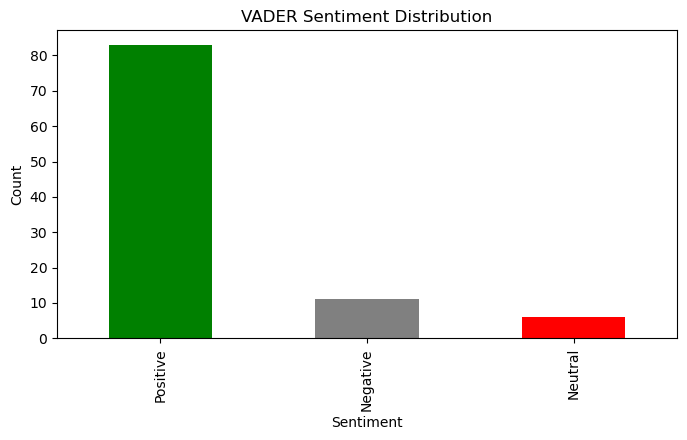

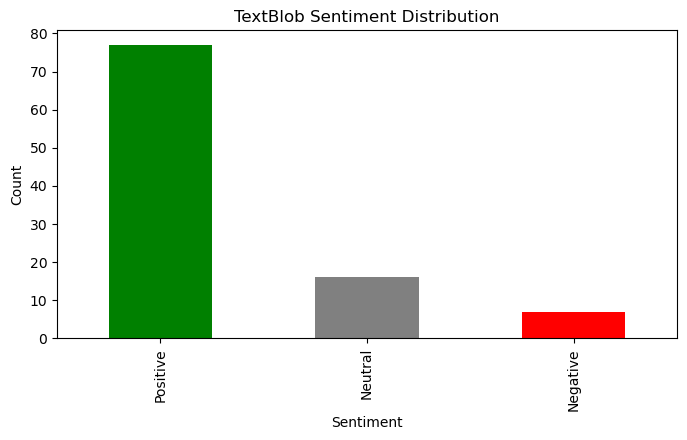

In [40]:
#visualize Sentiment Distribution
import matplotlib.pyplot as plt

# Count sentiment labels
vader_counts = random_sample["VADER_Sentiment"].value_counts()
textblob_counts = random_sample["TextBlob_Sentiment"].value_counts()

# Plot VADER Sentiment Distribution
plt.figure(figsize=(8, 4))
vader_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Plot TextBlob Sentiment Distribution
plt.figure(figsize=(8, 4))
textblob_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [41]:
#Questions: Do you agree with the models?
# we agree with the models(VADER and TextBlob), here are some key points: VADER is great for short, social media-like text and captures emotion-driven words well
#TextBlob has more rules and relies on world polarity, which might miss context and sarcasm

#if VADER and TextBlob both classify a review as "positive" or "negative", it is likely correct.
#if disagree, it suggests the text is more complex
#A neutral classfication might indicate mixed sentiments